# 関数

In [13]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):
    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 

    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.ylim((0,0.2))
    plt.show()
    plt.close()

In [65]:
import csv
def readCSV(file_path, parse_func) -> list[list]:
    data = None
    with open(file_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        data:list[list] = []
        for row in reader:
            row_data = []
            for d in row:
                row_data.append(parse_func(d))
            data.append(row_data)
    
    return data

In [95]:
import csv
import pprint
from sklearn.metrics import accuracy_score,multilabel_confusion_matrix,precision_score,recall_score,f1_score

def acc_est(clustering_result):
    _est(clustering_result, "./data/note_sims/sim_acc.csv", "./data/note_sims/not_sim_acc.csv")

def est(clustering_result):
    _est(clustering_result, "./data/note_sims/sim.csv", "./data/note_sims/not_sim.csv")

def _est(clustering_result, sim_file_path, nsim_file_path):
    count = len(clustering_result)
    labels = {True: "sim", False:"not sim", None:"none"}
    result_table = [[labels[i == j] for j in clustering_result] for i in clustering_result]
    sim_table = [[labels[None] for _ in clustering_result] for _ in clustering_result]
    # _sim_table = [[None for _ in clustering_result] for _ in clustering_result]
    sim_data = readCSV(sim_file_path, int)
    not_sim_data = readCSV(nsim_file_path, int)
    if not sim_data or sim_data is None or len(sim_data) == 0:
        print("load error")
        return
    if not not_sim_data or not_sim_data is None or len(not_sim_data) == 0:
        print("load error")
        return

    for [s,t] in sim_data:
        sim_table[s][t] = labels[True]
        sim_table[t][s] = labels[True]
    for [s,t] in sim_data:
        sim_table[s][t] = labels[False]
        sim_table[t][s] = labels[False]
    
    # with open(sim_file_path, newline='') as csvfile:
    #     reader = csv.reader(csvfile)
    #     for row in reader:
    #         s = int(row[0])
    #         t = int(row[1])
    #         sim_table[s][t] = True
    #         sim_table[t][s] = True
    
    # assert _sim_table == sim_table

    # with open(nsim_file_path, newline='') as csvfile:
    #     reader = csv.reader(csvfile)
    #     for row in reader:
    #         s = int(row[0])
    #         t = int(row[1])
    #         sim_table[s][t] = True
    #         sim_table[t][s] = True


    for i in range(count):
        for j in range(count):
            if sim_table[i][j] == labels[None]:
                result_table[i][j] = labels[None]

    flat_sim_table = sum(sim_table, [])
    flat_result_table = sum(result_table, [])
    # labels = ["True", "False", "None"]
    confusion_matrix = multilabel_confusion_matrix(flat_sim_table, flat_result_table, labels=list(labels.values()))
    accuracy = accuracy_score(flat_sim_table, flat_result_table)
    precision = precision_score(flat_sim_table, flat_result_table, average="micro")
    recall = recall_score(flat_sim_table, flat_result_table, average="micro")
    f1 = f1_score(flat_sim_table, flat_result_table, average="micro")
    print("\n===== 評価 =====")
    print(np.array([["tp rate", "fn rate"], ["tn rate", "tn rate"]]))
    for label, matrix in zip(labels.values(), confusion_matrix):
        print(f"{label=}")
        sm = sum(sum(matrix))
        print(f"{matrix/sm}")
    print(f"{accuracy=}")
    print(f"{precision=}")
    print(f"{recall=}")
    print(f"{f1=}")
    print("=================\n")
    # print(f"accuracy = {accuracy_score()}")

['./data/_json/feature_vector/test/song155_[cnt2_move]_fv.json']
eps = 0.05
silhouette score =  0.3749176036197572
acc

===== 評価 =====
[['tp rate' 'fn rate']
 ['tn rate' 'tn rate']]
label='sim'
[[9.99686220e-01 3.13779892e-04]
 [0.00000000e+00 0.00000000e+00]]
label='not sim'
[[9.99686220e-01 0.00000000e+00]
 [3.13779892e-04 0.00000000e+00]]
label='none'
[[3.13779892e-04 0.00000000e+00]
 [0.00000000e+00 9.99686220e-01]]
accuracy=0.9996862201083366
precision=0.9996862201083366
recall=0.9996862201083366
f1=0.9996862201083366

not acc

===== 評価 =====
[['tp rate' 'fn rate']
 ['tn rate' 'tn rate']]
label='sim'
[[9.99207293e-01 7.92707095e-04]
 [0.00000000e+00 0.00000000e+00]]
label='not sim'
[[9.99124719e-01 0.00000000e+00]
 [7.92707095e-04 8.25736557e-05]]
label='none'
[[8.75280750e-04 0.00000000e+00]
 [0.00000000e+00 9.99124719e-01]]
accuracy=0.9992072929052715
precision=0.9992072929052715
recall=0.9992072929052715
f1=0.9992072929052715

eps = 0.1
silhouette score =  0.3785714452051314
ac

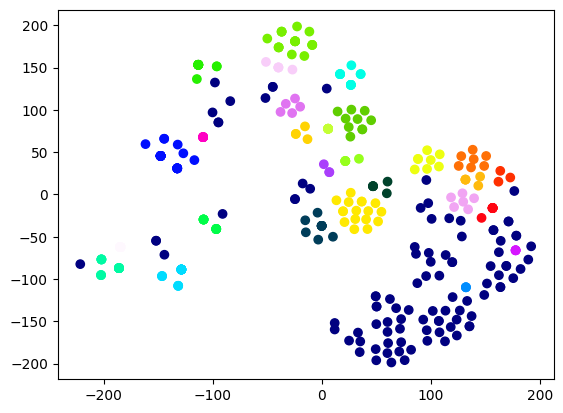

In [96]:
# %pip install sklearn
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import os
import json
import glob
import csv
import pprint
import matplotlib.pyplot as plt

save_dir = "./data/_json/0724/clustering_result"
os.makedirs(save_dir, exist_ok=True)
save_file_name = "clustering_data.csv"
with open(f"{save_dir}/{save_file_name}", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["id","x", "y", "label"])

notes_file_paths = glob.glob("./data/_json/feature_vector/test/*cnt2_move*.json")
notes_file_paths = [f for f in notes_file_paths if "155" in f]
pprint.pprint(notes_file_paths)
for eps,file_path in enumerate(notes_file_paths):
    data = None
    id = None
    with open(file_path, newline="") as f:
        content = json.load(f)        
        data = preprocessing.StandardScaler().fit_transform(np.array(content["data"]))
        id = content["id"]

    # pprint.pprint(data)
    if data is None or id is None:
        print(f"{file_path} file is not found")
        continue
    # k = 2 * len(data[0]) - 1 # k=2*{dim(dataset)} - 1
    # get_kdist_plot(X=data, k=k)
    # クラスタリング
    range_max = 1
    range_step = 20
    range_min = range_max/range_step
    step = range_max/range_step
    now = range_min
    rng = []
    for i in range(range_step):
        rng.append(now)
        now += step
    # print(rng)

    for eps in rng:
        clustering_result = DBSCAN(eps=eps, min_samples=3).fit_predict(data)
        clustering_result += 1
        # pprint.pprint(clustering_result)
        print(f"eps = {eps}")
        print("silhouette score = ", silhouette_score(data, clustering_result))
        print("acc")
        acc_est(clustering_result)
        print("not acc")
        est(clustering_result)

    # 0.003250035
    clustering_result = DBSCAN(eps=0.003250035, min_samples=3).fit_predict(data)
    clustering_result += 1
    # 次元削減
    tsne = TSNE(n_components=2, random_state=0)
    data_tsne = tsne.fit_transform(data)
    
    plt.scatter(data_tsne[:,0],data_tsne[:,1], c=clustering_result, cmap="gist_ncar")
    plt.show()

    # 各区間ごとのデータ
    # for d in zip(data_tsne, clustering_result):
    #     print(d)
    clustering_data = [[id,float(pos[0]), float(pos[1]), int(l)]for (pos, l) in zip(data_tsne, clustering_result)]

    with open(f"{save_dir}/{save_file_name}", "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(clustering_data)